# Question 2

In [1]:
!pip install sobol_seq

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import sobol_seq
import seaborn as sns
import time
from scipy.stats import qmc
from scipy.stats import norm
import chaospy as ch

In [4]:
# CIR model parameters
a = 0.15
b = 0.2
sigma = 0.2
r = 0.05
S_0 = 5

# Asian option additional parameters
K = 4
M = 4 # It should be an int >= 2
T = 1

# MLMC parameters
initial_level = 0
target_epsilon = 0.01
C = 10**4  # Overall computational budget. (It should be 10**4)

In [5]:
def payoff_call(S, K):
    return np.maximum(np.mean(S)-K, 0)* np.exp(-r * T)
    
def payoff_put(S, K):
    return np.maximum(K-np.mean(S), 0)* np.exp(-r * T)

In [6]:
def quasi_monte_carlo(f, no_of_paths, n_steps=20, S_0=5, T=1, r=0.05, sigma=0.3, K=4):
  
    h = T / n_steps
    present_payoffs = np.zeros(no_of_paths)
    dW = np.mod(sobol_seq.i4_sobol_generate(n_steps, no_of_paths)+np.random.uniform(size=(no_of_paths,n_steps)),1)
    dW = norm.ppf(dW)
    for k in range(no_of_paths):
        S = np.zeros(n_steps)
        S[0] = S_0
        for i in range(1, n_steps):
            S[i] = S[i-1]+ a*(b-S[i-1])*h + sigma*np.sqrt(max(S[i-1], 0.0))*dW[k, i]*np.sqrt(h)
        present_payoffs[k] = f(S, K)
    return present_payoffs

In [7]:
def CI_calc(s_array):
    X_bar = np.mean(s_array)
    Upper_b = X_bar + (np.sqrt(np.var(s_array)) * norm.ppf(0.975)) / np.sqrt(len(s_array))
    Lower_b = X_bar - (np.sqrt(np.var(s_array)) * norm.ppf(0.975)) / np.sqrt(len(s_array))
    return np.array([Lower_b, Upper_b])

In [8]:
S_0 = 5
K = 4


payoffs = quasi_monte_carlo(f = payoff_call, no_of_paths=100, n_steps=40)

In [9]:
mlmc_cpu_time = 7.029
elapsed_time = 0

paths = 300

while elapsed_time < mlmc_cpu_time:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(np.nan_to_num(quasi_monte_carlo(f = payoff_call, no_of_paths=paths,n_steps=40))))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    print(paths)
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    print(mc_var, average_mc_price)
    paths+=100

average_mc_price = np.mean(mc_estimates)
mc_var = np.var(mc_estimates)

300
0.0003530032814460004 0.637104875259179


KeyboardInterrupt: 

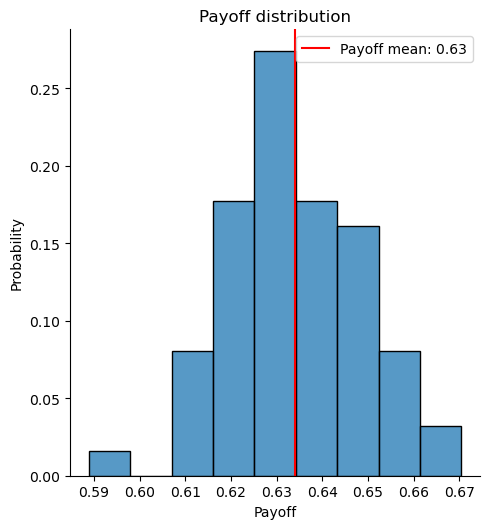

In [10]:
sns.displot(mc_estimates, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('Payoff')
payoff_mean=np.mean(mc_estimates)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()

In [17]:
mlmc_var = 2.107e-05
mc_var = 10**10

paths = 2000
times = [] 
varis = []
while mlmc_var < mc_var:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(np.nan_to_num(quasi_monte_carlo(f = payoff_call, no_of_paths=paths,n_steps=40))))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    times.append(elapsed_time)
    varis.append(mc_var)
    print(mc_var, average_mc_price)
    print(elapsed_time)
    paths+=500

3.898508543507975e-05 0.6345276971633093
36.81641300000001
4.094196906344763e-05 0.6377344322355555
45.51977299999999
3.192681400514139e-05 0.6357126743705817
55.26357699999994
3.268515068266003e-05 0.6359074348519758
64.583484
2.6875638020588814e-05 0.6355093801362994
73.64329300000009
2.8071535505485522e-05 0.6362805322965622
82.93562399999996


KeyboardInterrupt: 

### It is a begining of the output, because computations take too long: 82.93562399999996 seconds

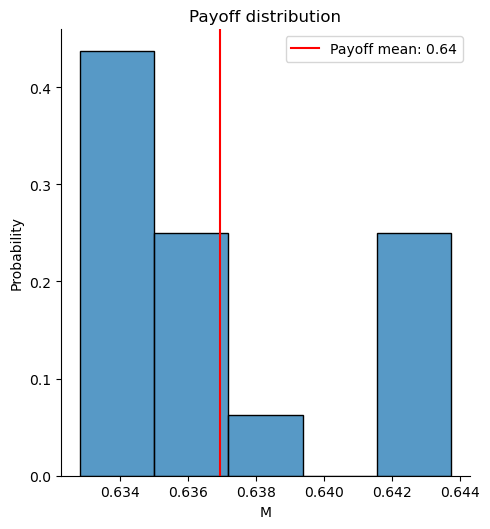

In [18]:
sns.displot(mc_estimates, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('M')
payoff_mean=np.mean(mc_estimates)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()

In [21]:
max_sample = 10000

confidence_intervals = np.array([None, None])
payoffs= []

for n_sample in range(10, max_sample + 1, 10):
    payoff = quasi_monte_carlo(f=payoff_call, no_of_paths=n_sample,n_steps=40)
    payoffs.append(np.mean(payoff))
    confidence_intervals = np.row_stack((confidence_intervals, CI_calc(payoff)))

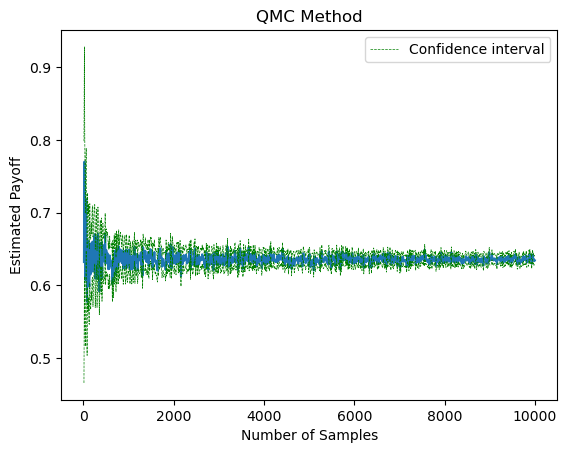

In [22]:
x_axis1 = range(10, max_sample + 1, 10)
plt.plot(x_axis1, payoffs)
plt.plot(x_axis1, confidence_intervals[1:, 0], 'g--', lw=0.5, label='Confidence interval')
plt.plot(x_axis1, confidence_intervals[1:, 1], 'g--', lw=0.5)
plt.xlabel("Number of Samples")
plt.ylabel("Estimated Payoff")
plt.title("QMC Method")
plt.legend()
plt.show()